# Code

In [259]:
type(g_i)

plxscripting.plxproxy.PlxProxyGlobalObject

## Package import

In [1]:
from plxscripting.easy import *
password = "nicFgr^TtsFm~h~M"
localhostport_input = 10000 
localhostport_output = 10001
s_i, g_i = new_sberver('localhost', localhostport_input, password=password) 
s_o, g_o = new_server('localhost', localhostport_output, password=password)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numbers
import numpy as np
import pandas as pd

In [257]:
import textwrap

In [245]:
dstrata = [1,2,3]
model_height = 5
if isinstance(dstrata, numbers.Number):
    dstrata = [dstrata]
dstrata = np.array(dstrata)
dstrata = dstrata[np.cumsum(dstrata) < model_height]
dstrata = np.concatenate([dstrata, [model_height - np.sum(dstrata)]])
dstrata = dstrata
nstrata = len(dstrata)

In [246]:
dstrata

array([1, 2, 2])

In [247]:
nstrata

3

## Model init

In [200]:
def set_model(title, comments, mdltype):
    g_i.setproperties("Title",title, "Comments",comments, "ModelType",mdltype)

In [204]:
# plain stran model set up
title = 'example'
comments = 'This is an example of a plain-strain model'
mdltype = 'planestrain'
set_model(title, comments, mdltype)

In [206]:
# axisymmetryc model set up
title = 'example'
comments = 'This is an example of a axisymmetryc model'
mdltype = 'axisymmetry '
set_model(title, comments, mdltype)

## Geometry

In [ ]:
def get_geometry(B, D, dstrata=None, fill_angle=None, wt=None, B_fill=0.5, nfill=None, dfill=None, Dunder=None):
    if fill_angle is None:
        geo['fill'] = False
    if Dunder is None:
        geo['under'] = False
    if wt is None:
        geo['wt'] = False
    else:
        geo['wt'] = geo['ymax'] - wt

In [217]:
def get_geometry(B, D, fill_angle, D_x=0.1, B_fill=0.5, nfill=1, wt=None):
    geo = {}
    geo['B'] = B
    geo['D'] = D
    geo['fill angle'] = fill_angle
    geo['nfill'] = nfill


    x_bottom  = B/2 + B_fill
    x_top = B/2 + B_fill + D / np.tan(np.radians(fill_angle))
    y_bottom = 3 * B
    y_top = 3 * B + D
    x = np.linspace(x_top, x_bottom, nfill + 1)
    y = np.linspace(y_top, y_bottom, nfill + 1)
    for idx in range(nfill + 1):
        geo['F{:.0f}'.format(idx+1)] = np.array([x[idx], y[idx]])
        geo['B{:.0f}'.format(idx+1)] = np.array([0, y[idx]])
    geo['B{:.0f}'.format(nfill+2)] = np.array([B/2, 3 * B])
    
    geo['fill'] = []
    for idx in range(nfill):
        b_top = 'B{:.0f}'.format(idx + 1)
        b_bottom = 'B{:.0f}'.format(idx + 2)
        f_top = 'F{:.0f}'.format(idx + 1)
        f_bottom = 'F{:.0f}'.format(idx + 2)
        geo['fill'].append(np.array([geo[b_top], geo[f_top],
                                     geo[f_bottom], geo[b_bottom]]))    
    
    geo['S1'] = np.array([B/2 + B_fill + D / np.tan(np.radians(fill_angle)) + 0.5 * B, 3 * B + D])
    geo['S2'] = np.array([B/2 + B_fill + D / np.tan(np.radians(fill_angle)) + 0.5 * B, 0])
    geo['S3'] = np.array([0, 0])
    geo['S4'] = np.array([0, 3 * B - D_x])
    geo['S5'] = np.array([B/2 + B_fill, 3 * B - D_x])
    
    geo['chimney'] = np.array([geo['B1'], geo['B{:.0f}'.format(nfill + 1)]])
    geo['footing'] = np.array([geo['B{:.0f}'.format(nfill + 1)], geo['B{:.0f}'.format(nfill + 2)]])
    geo['soil'] = np.array([geo['S1'], geo['S2'], geo['S3'], geo['S4'], geo['S5'],
                            geo['F{:.0f}'.format(nfill+1)], geo['F1']])
    geo['under_footing'] = np.array([geo['B{:.0f}'.format(nfill+1)],
                                     geo['F{:.0f}'.format(nfill+1)],
                                     geo['S5'],
                                     geo['S4']])
    
    geo['fill contour'] = np.array([geo['B1'], geo['F1'],
                                    geo['F{:.0f}'.format(nfill+1)],
                                    geo['B{:.0f}'.format(nfill+1)],
                                    geo['B1']])
    geo['soil contour'] = np.array([geo['S1'], geo['S2'], geo['S3'],
                                    geo['B{:.0f}'.format(nfill+1)],
                                    geo['F{:.0f}'.format(nfill+1)],
                                    geo['F1'], geo['S1']])
    
    geo['xmin'] = 0 
    geo['xmax'] = B/2 + B_fill + D / np.tan(np.radians(fill_angle)) + 0.5 * B
    geo['ymin'] = 0
    geo['ymax'] = 3 * B + D
    if wt is None:
        geo['wt'] = 0
    else:
        geo['wt'] = np.max([geo['ymax'] - wt, 0])
    return geo

def plot_geometry(geo, footing=True):
    fig, ax = plt.subplots(1, 1, figsize=(6,6 * geo['ymax']/geo['xmax']))

    patches = []
    for fill in geo['fill']:
        patches.append(Polygon(fill, True))
    patches.append(Polygon(geo['soil'], True))
    patches.append(Polygon(geo['under_footing'], True))

    colors = ['greenyellow'] * geo['nfill'] + ['tan', 'darkolivegreen']
    p = PatchCollection(patches, alpha=.4, facecolor=colors, lw=1, edgecolor='k')
    ax.add_collection(p)

    ax.plot(geo['fill contour'][:, 0], geo['fill contour'][:, 1],'-k', lw=1)
    ax.plot(geo['soil contour'][:, 0], geo['soil contour'][:, 1],'-k', lw=1)
    if footing:
        ax.plot(geo['chimney'][:, 0], geo['chimney'][:, 1],'-', color='grey', lw=10)
        ax.plot(geo['footing'][:, 0], geo['footing'][:, 1],'-', color='grey', lw=10)
    ax.plot([geo['xmin'], geo['xmax']], [geo['wt'], geo['wt']], '-b', lw=3)

    ax.set_xlim([0, 1.2 * geo['xmax']])
    ax.set_ylim([0, 1.2 * geo['ymax']])
    ax.grid(alpha=0.4)
    plt.close(fig)
    return fig

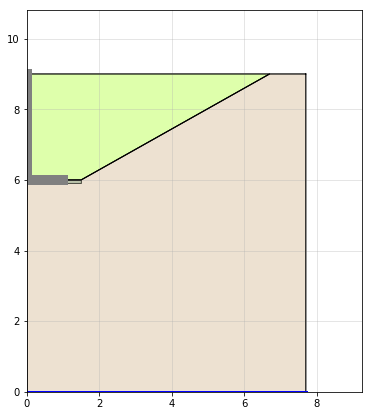

In [216]:
# The model geoemtry is defined by the foundation depth D, widht B
# and angle of the fill:
B = 2
D = 3
fill_angle = 30
geo = get_geometry(B, D, fill_angle)
# By default the model has a depth of 3B below the foundation level
# and a width of B/2 after the fill reaches the surface
plot_geometry(geo)

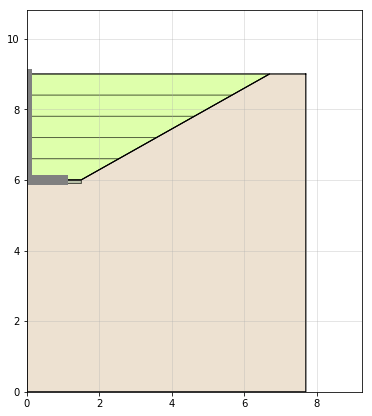

In [208]:
# The fill can be subdivided in nfill layers to which different materials
# are assigned
B = 2
D = 3
fill_angle = 30
geo = get_geometry(B, D, fill_angle, nfill=5)
plot_geometry(geo)

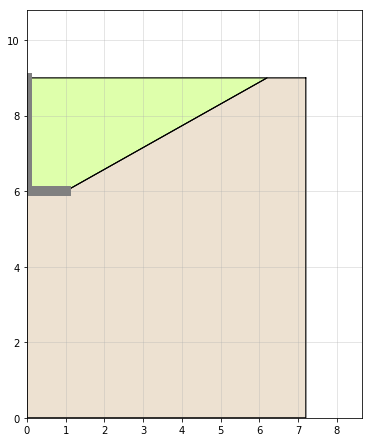

In [209]:
# The distance from the footing edge to the end of the 
# fill is controlled with the B_fill argument
B = 2
D = 3
fill_angle = 30
geo = get_geometry(B, D, fill_angle, B_fill=0)
plot_geometry(geo)

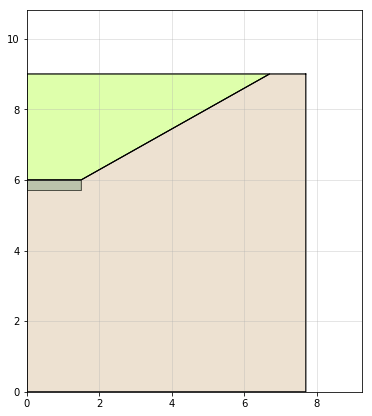

In [212]:
# A layer of soil is created under the foundation. This
# layer can be assigend a different material after uplift
# to simulate the effect of xxxxx. The width of this layer
# is controlled by the D_x argument
B = 2
D = 3
fill_angle = 30
geo = get_geometry(B, D, fill_angle, D_x=.3)
# the foundation can be turn off from the plot
plot_geometry(geo, footing=False)

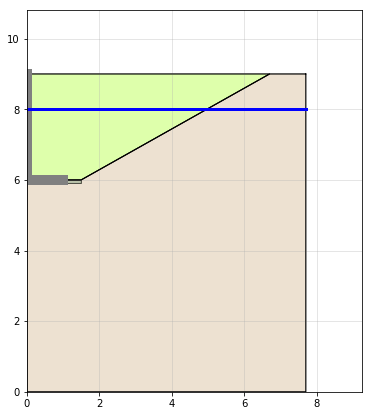

In [221]:
# The water table depth is specified with the wt argument
B = 2
D = 3
fill_angle = 30
geo = get_geometry(B, D, fill_angle, wt=1)
plot_geometry(geo)

In [81]:
def build_geometry(mdl, geo):
    g_i.gotostructures()
    mdl['nfill'] = geo['nfill']
    # fill
    for idx, fill in enumerate(geo['fill']):
        args = [list(v) for v in fill]
        out = g_i.polygon(*args)
        mdl['polygon_fill_{:.0f}'.format(idx+1)] = out[0]
        mdl['soil_fill_{:.0f}'.format(idx+1)] = out[1]
    # soil
    args = [list(v) for v in geo['soil']]
    out = g_i.polygon(*args)
    mdl['polygon_soil'] = out[0]
    mdl['soil_sand'] = out[1]
    # under footing
    args = [list(v) for v in geo['under_footing']]
    out = g_i.polygon(*args)
    mdl['polygon_under_footing'] = out[0]
    mdl['soil_under_footing'] = out[1]
    
    # chimney
    out_plate = g_i.plate(*[list(v) for v in geo['chimney']])
    mdl['chimney_point_1'] = out_plate[0]
    mdl['chimney_point_2'] = out_plate[1]
    mdl['chimney_line'] = out_plate[2]
    mdl['chimney_plate'] = out_plate[3]
    #mdl['chimney_plate'].set_material(mdl['chimney'])
    out_int = g_i.posinterface(*[list(v) for v in geo['chimney']])
    mdl['chimney_int_point_1'] = out_int[0]
    mdl['chimney_int_point_2'] = out_int[1]
    mdl['chimney_int_line'] = out_int[2]
    mdl['chimney_int'] = out_int[3]
    # footing
    out = g_i.plate(*[list(v) for v in geo['footing']])
    mdl['footing_point_1'] = out[0]
    mdl['footing_point_2'] = out[1]
    mdl['footing_line'] = out[2]
    mdl['footing_plate'] = out[3]
    #mdl['footing_plate'].set_material(mdl['footing'])
    out = g_i.posinterface(*[list(v) for v in geo['footing']])
    mdl['footing_pos_int_point_1'] = out[0]
    mdl['footing_pos_int_point_2'] = out[1]
    mdl['footing_pos_int_line'] = out[2]
    mdl['footing_pos_int'] = out[3]
    out = g_i.neginterface(*[list(v) for v in geo['footing']])
    mdl['footing_neg_int_point_1'] = out[0]
    mdl['footing_neg_int_point_2'] = out[1]
    mdl['footing_neg_int_line'] = out[2]
    mdl['footing_neg_int'] = out[3]
    # load
    mdl['load_point'], mdl['load'] = g_i.pointload(list(geo['B1']))
    return mdl

## Material properties

### Soil materials

In [195]:
def set_soil_material(mdl, label, material):
    g_i.gotosoil()
    if 'soil material' not in mdl:
        mdl['soil material'] = {}
    if label in mdl['soil material']:
        raise RuntimeError("Duplicated soil material {}".format(label))

    if material["SoilModel"] == 'elastic':
        mdl = set_elastic(mdl, label, material)
    elif material["SoilModel"] == 'mohr-coulomb':
        mdl = set_mc(mdl, label, material)
    elif material["SoilModel"] == 'hardening soil':
        mdl = set_hs(mdl, label, material)
    return mdl

def set_elastic(mdl, label, material):
    if 'kx' not in material:
        material['kx'] = 0
    if 'ky' not in material:
        material['ky'] = 0
    if 'Rinter' not in material:
        material['Rinter'] = 1
    
    mdl['soil material'][label] = g_i.soilmat("MaterialName",label,
                                              "SoilModel", 1,
                                              "DrainageType", material["DrainageType"] ,
                                              "Eref", material['Eref'],
                                              "nu", material['nu'],
                                              "gammaSat", material['gammaSat'],
                                              "gammaUnsat", material['gammaUnsat'],
                                              'perm_primary_horizontal_axis', material['kx'],
                                              'perm_vertical_axis', material['ky'],
                                              'Rinter', material['Rinter'])
    return mdl

def set_mc(mdl, label, material):
    if 'kx' not in material:
        material['kx'] = 0
    if 'ky' not in material:
        material['ky'] = 0
    if 'Rinter' not in material:
        material['Rinter'] = 1
    if 'OCR' not in material:
        material['OCR'] = 1
    if 'POP' not in material:
        material['POP'] = 0
    mdl['soil material'][label] = g_i.soilmat("MaterialName",label,
                                              "SoilModel", 2,
                                              "DrainageType", material["DrainageType"] ,
                                              "Eref", material['Eref'],
                                              "nu", material['nu'],
                                              'cref', material['cref'],
                                              'phi', material['phi'],
                                              'psi', material['psi'],
                                              "gammaSat", material['gammaSat'],
                                              "gammaUnsat", material['gammaUnsat'],
                                              'OCR',material['OCR'],
                                              'POP',material['POP'],
                                              'perm_primary_horizontal_axis', material['kx'],
                                              'perm_vertical_axis', material['ky'],
                                              'Rinter', material['Rinter'])
    return mdl

def set_hs(mdl, label, material):
    if 'kx' not in material:
        material['kx'] = 0
    if 'ky' not in material:
        material['ky'] = 0
    if 'Rinter' not in material:
        material['Rinter'] = 1
    if 'K0nc' not in material:
        material['K0nc'] = 1 - np.sin(np.radians(material['phi']))
    if 'OCR' not in material:
        material['OCR'] = 1
    if 'POP' not in material:
        material['POP'] = 0
    mdl['soil material'][label] = g_i.soilmat("MaterialName",label, 
                                              "SoilModel", 3,
                                              "DrainageType", material["DrainageType"] ,
                                              "gammaSat", material['gammaSat'],
                                              "gammaUnsat", material['gammaUnsat'],
                                              'einit', material['e0'],
                                              'E50ref',material['E50ref'],
                                              'EoedRef', material['Eoedref'],
                                              'EurRef', material['Euref'],
                                              'powerm', material['powerm'], 
                                              'cref', material['c'],
                                              'phi', material['phi'],
                                              'psi', material['psi'],
                                              'nu', material['nu'], 
                                              'K0nc',material['K0nc'],
                                              'OCR',material['OCR'],
                                              'POP',material['POP'],
                                              'perm_primary_horizontal_axis', material['kx'],
                                              'perm_vertical_axis', material['ky'],
                                              'Rinter', material['Rinter'])
    return mdl

In [196]:
# example of elastic material
concrete = {}
concrete['SoilModel'] = 'elastic'
concrete["DrainageType"] = 0
concrete['Eref'] = 4700 *  np.sqrt(24000) # kPa
concrete['nu'] = 0.4 #
concrete['gammaSat'] = 17
concrete['gammaUnsat'] = 20
# optional parameters
#sand['kx'] = 1
#sand['ky'] =1
#sand['Rinter'] = 0.67


mdl = {}
mdl = set_soil_material(mdl, 'concrete', concrete)
# the elastic soil material is sotred in:
mdl['soil material']

{'concrete': <SoilMat {57D2EFC2-63D6-43C0-85C4-4458753C905A}>}

In [197]:
# example of Hardening soil material
sand = {}
sand['SoilModel'] = 'hardening soil'
sand["DrainageType"] = 0
sand['gammaSat'] = 17
sand['gammaUnsat'] = 20
sand['e0'] = 0.2
sand['E50ref'] = 4e4
sand['Eoedref'] = 4e4
sand['Euref'] = 1.2e5
sand['powerm'] = 0.5
sand['c'] = 0
sand['phi'] = 32
sand['psi'] = 2
sand['nu'] = 0.2
# optional parameters
#sand['K0nc'] = 0.6
#sand['kx'] = 1
#sand['ky'] =1
#sand['Rinter'] = 0.67

mdl = {}
mdl = set_soil_material(mdl, 'hs', sand)
# the Hardening soil material is sotred in:
mdl['soil material']

{'hs': <SoilMat {F1CDFF8A-22AC-4C64-B830-D03F59D10E80}>}

In [198]:
# example of Mohr-Coulomb soil material
sand = {}
sand['SoilModel'] = 'mohr-coulomb'
sand["DrainageType"] = 0
sand['gammaSat'] = 17
sand['gammaUnsat'] = 20
sand['e0'] = 0.2
sand['Eref'] = 4e4
sand['nu'] = 0.2
sand['cref'] = 0
sand['phi'] = 32
sand['psi'] = 2
# optional parameters
#sand['kx'] = 1
#sand['ky'] =1
#sand['Rinter'] = 0.67

mdl = {}
mdl = set_soil_material(mdl, 'mc', sand)
# the Mohr-Coulbom soil material is sotred in:
mdl['soil material']

{'mc': <SoilMat {03B58F92-2BE6-4CA3-B08D-AFE141A4E4DB}>}

### Plate materials

In [179]:
def set_plate_material(mdl, label, material):
    g_i.gotosoil()
    if 'plate material' not in mdl:
        mdl['plate material'] = {}
    if label in mdl['plate material']:
        raise RuntimeError("Duplicated plate material {}".format(label))
    mdl['plate material'][label] = g_i.platemat("MaterialName", label,
                                                "MaterialNumber", 0,
                                                "Elasticity", 0,
                                                "IsIsotropic", True,
                                                 "EA", material['EA'],
                                                 "EA2", material['EA'],
                                                 "EI", material['EI'],
                                                 "nu", material['nu'],
                                                 "d", material['d'],
                                                 "Gref", material['Gref'])
    return mdl
    
def set_concrete_plate(fc, gamma, d, young_modulus=None, poisson=0.4):
    concrete = {}
    concrete['fc'] = fc * 1000 # kPa
    if young_modulus is None:
        concrete['E'] = 4700 *  np.sqrt(concrete['fc']) # kPa
    else:
        concrete['E'] = young_modulus
    concrete['nu'] = poisson 
    concrete['EA'] = concrete['E'] * d
    concrete['EI'] = concrete['E'] * d**3/12
    concrete['d'] = np.sqrt(12 * concrete['EI'] / concrete['EA'])
    concrete['Gref'] = concrete['EA'] / concrete['d']  / (2 * (1 + concrete['nu'])) # KPa
    return concrete

In [182]:
# Create H30 concrete slab with a 40cm thickness and 24kN/m3 unit weight
concrete = set_concrete_plate(30, 24, 0.4)
# By default the Young modulus is computed from fc, but it can be user specified, as the poisson ratio
# concrete = set_concrete_plate(30, 24, 0.4, young_modulus=85000, poisson=0.3)

mdl = {}
mdl = set_plate_material(mdl, 'concrete', concrete)
# the plate material is sotred in:
mdl['plate material']

{'concrete': <PlateMat2D {8C0CD7AA-FF98-4F17-8CED-D4F921118653}>}

### Model materials

In [98]:
def build_materials(mdl, materials): 
    set_soil_material(mdl, 'soil', materials['soil'])
    if 'under footing' not in materials:
        materials['under footing'] = material['soil']
    set_soil_material(mdl, 'under footing', materials['under footing'])
    
    
    nfill = mdl['nfill']
    if not isintance(material['fill'], list):
        materials['fill'] = [materials['fill']] * nfill
    if len(materials['fill']) != mdl['nfill']:
        raise RuntimeError('{:.0f} must be specified.'.format(mdl['nfill']))
    for idx, fill in enumerate(material['fill']):
        lbl = "fill_{:.0f}".format(idx + 1)
        set_soil_material(mdl, lbl, fill)
        
    set_plate_material(mdl, 'chimney', materials['chimney'])
    set_plate_material(mdl, 'footing', materials['footing'])
    return mdl

def del_materials(mdl):
    g_i.gotosoil()
    g_i.delete(mdl['plate material']['chimney'])
    g_i.delete(mdl['plate material']['footing'])
    _ = mdl.pop('plate material')
    for soil in mdl['soil material']:
        g_i.delete(soil)
    _ = mdl.pop('soil material')

## Phases

In [240]:
def set_load_test(g_i, mdl, testid, start_phase_id, loads):
    if 'test ids' not in mdl.keys():
        mdl['test ids'] = {}
    if testid in mdl['test ids'].keys():
        print('Duplicated test id')
        return
    mdl['test ids'][testid] = []
    if isinstance(loads, numbers.Number):
        loads = [loads]
    phaseids = [testid + '_stage_{:.0f}'.format(idx) for idx in range(len(loads))]
    previous_phase = [start_phase_id] + phaseids[:-1]
    for load, pidx, previdx in zip(loads, phaseids, previous_phase):
        mdl['test ids'][testid].append(pidx)
        mdl['iphases'][pidx] = g_i.phase(mdl['iphases'][previdx])
        mdl['iphases'][pidx].Identification = pidx
        g_i.Model.CurrentPhase = mdl['iphases'][pidx]
        g_i.activate(mdl['B1_point'], g_i.Model.CurrentPhase)
        g_i.set(g_i.PointLoad_1_1.Fy, g_i.Model.CurrentPhase, load)

In [239]:
def build_initial_phases(mdl):
    mdl['iphases'] = {}
    g_i.gotostages()
    
    mdl['iphases']['Initial phase'] = g_i.InitialPhase
    g_i.Model.CurrentPhase = g_i.InitialPhase
    g_i.activate(mdl['polygon_sand'], g_i.Model.CurrentPhase)
    g_i.activate(mdl['polygon_under_footing'], g_i.Model.CurrentPhase)
    
    for idx in range(mdl['nfill']):
        fill = g_i.get_equivalent(mdl['polygon_fill_{:.0f}'.format(idx+1)])
        g_i.activate(fill, g_i.Model.CurrentPhase)
    g_i.deactivate(mdl['chimney_plate'], g_i.Model.CurrentPhase)
    g_i.deactivate(mdl['footing_plate'], g_i.Model.CurrentPhase)

    
    
    g_i.set(g_i.Soil_1_1.Material, g_i.Model.CurrentPhase, mdl['sand'])

    g_i.set(g_i.PointLoad_1_1.Fy, g_i.Model.CurrentPhase, 0)
    
    mdl['iphases']['excavation'] = g_i.phase(g_i.InitialPhase)
    mdl['iphases']['excavation'].Identification = "excavation"
    g_i.Model.CurrentPhase = mdl['iphases']['excavation']
    g_i.deactivate(mdl['polygon_fill'], g_i.Model.CurrentPhase)

    mdl['iphases']['construction'] = g_i.phase(mdl['iphases']['excavation'])
    mdl['iphases']['construction'].Identification = "construction"
    g_i.Model.CurrentPhase = mdl['iphases']['construction']
    g_i.activate(mdl['polygon_fill'], g_i.Model.CurrentPhase)
    g_i.activate(mdl['lineB1B2_plate'], g_i.Model.CurrentPhase)
    g_i.activate(mdl['lineB2B3_plate'], g_i.Model.CurrentPhase)

    g_i.set(g_i.Soil_2_1.Material, g_i.Model.CurrentPhase, mdl['fill'])

    '''
    mdl['iphases']['loading'] = g_i.phase(mdl['iphases']['construction'])
    mdl['iphases']['loading'].Identification = "loading"
    g_i.Model.CurrentPhase = mdl['iphases']['loading']
    g_i.activate(mdl['B1_point'], g_i.Model.CurrentPhase)
    g_i.set(g_i.PointLoad_1_1.Fy, g_i.Model.CurrentPhase, -100)
    
    mdl['iphases']['pullout'] = g_i.phase(mdl['iphases']['loading'])
    mdl['iphases']['pullout'].Identification = "pullout"
    g_i.Model.CurrentPhase = mdl['iphases']['pullout']
    g_i.set(g_i.PointLoad_1_1.Fy, g_i.Model.CurrentPhase, 20)
    '''
    return mdl

def del_phases(mdl):
    g_i.gotostages()
    if 'ophases' in mdl.keys():
        _ = mdl.pop('ophases')
    if 'iphases' not in mdl.keys():
        return
    for phase_id in list(mdl['iphases'].keys())[::-1][:-1]:
        g_i.delete(mdl['iphases'][phase_id])
    _ = mdl.pop('iphases')
    if 'test ids' in mdl.keys():
        _ = mdl.pop('test ids')
    g_i.Model.CurrentPhase = g_i.InitialPhase
    g_i.deactivate(mdl['polygon_sand'], g_i.Model.CurrentPhase)
    g_i.deactivate(mdl['polygon_fill'], g_i.Model.CurrentPhase)

In [190]:
def select_points(geo):
    g_i.selectmeshpoints()
    g_o.addcurvepoint("node",[0, geo['ymax']])
    g_o.update()

In [191]:
def build_model(title, comments, B, D, fill_angle, mesh_density, material):
    mdl = {}
    geo = get_geometry(B, D, fill_angle)
    fig = plot_geometry(geo)
    set_prop(title, comments)
    mdl = build_geometry(mdl, geo)
    mdl = build_materials(mdl, material)
    g_i.gotomesh()
    mesh = g_i.mesh(mesh_density)
    mdl = build_phases(mdl)
    select_points(geo)  
    return mdl, fig

In [249]:
def get_results(mdl, g_i, g_o):
    # open output
    g_i.view(g_i.Phases[0])
    # create dictionary with output phases with the same name that input phases
    mdl['ophases'] = {}
    for phase in g_o.phases:
        internal_id = phase.Name.value
        user_given_id = phase.Identification.value
        user_given_id =  user_given_id[:-(len(internal_id) + 3)]
        mdl['ophases'][user_given_id] = phase
    
    # retrieve data
    phases = list(mdl['iphases'].keys())
    phases.remove('Initial phase')
    phases.remove('excavation')
    mdl['results'] = {}
    for phaseid in phases:
        previous_iphase = mdl['iphases'][phaseid].PreviousPhase
        current_iphase = mdl['iphases'][phaseid]
        current_ophase = mdl['ophases'][phaseid]
        Uy = []
        Fy = []
        sumMstage = []
        load_start = 0
        load_end = 0
        if g_i.PointLoad_1_1.Active[previous_iphase] is not None:
            if g_i.PointLoad_1_1.Active[previous_iphase].value:
                load_start = g_i.PointLoad_1_1.Fy[current_iphase].value
        if g_i.PointLoad_1_1.Active[current_iphase] is not None:
            if g_i.PointLoad_1_1.Active[current_iphase].value:
                load_end = g_i.PointLoad_1_1.Fy[current_iphase].value

        for step in current_ophase.Steps.value:
            Uy.append(g_o.getcurveresults(g_o.Nodes[0], step, g_o.ResultTypes.Plate.Uy))
            sumMstage.append(step.Reached.SumMstage.value)
        Fy = np.zeros_like(Uy)
        sumMstage = np.array(sumMstage)

        if g_i.PointLoad_1_1.Active[current_iphase].value:

            Fy = load_start + (load_end - load_start) * sumMstage

        mdl['results'][phaseid] = {}
        mdl['results'][phaseid]['load start'] = [load_start] * len(Uy)
        mdl['results'][phaseid]['load end'] = [load_end] * len(Uy)
        mdl['results'][phaseid]['uy'] = Uy
        mdl['results'][phaseid]['fy'] = Fy
        mdl['results'][phaseid]['sumMstage'] = sumMstage
    # build df
    results_df = pd.DataFrame()
    for phaseid in mdl['results']:
        df = pd.DataFrame(mdl['results'][phaseid])
        df['phase'] = phaseid
        df['plx id'] = mdl['iphases'][phaseid].Name.value
        df['previous plx id'] = mdl['iphases'][phaseid].PreviousPhase.Name.value
        df['previous'] = mdl['iphases'][phaseid].Identification.value
        results_df = pd.concat([results_df, df])
    
    results_df.loc[results_df['phase']=='construction','test'] = 'construction'
    for tid in mdl['test ids']:
        for stage in mdl['test ids'][tid]:
            results_df.loc[results_df['phase']==stage,'test'] = tid
    return results_df

In [301]:
def plot_test(results_df, testid, figsize=(7, 5), offset_construction=True):
    construction_disp = 0
    if offset_construction:
        construction_disp = results_df.loc[results_df['phase']=='construction', 'uy'].min()
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    idx = results_df['test']==testid
    for sidx, stage in enumerate(results_df.loc[idx, 'phase'].unique()):
        idx2 = (idx) & (results_df['phase']==stage)
        uy = results_df.loc[idx2,'uy'].to_numpy() - construction_disp
        fy = results_df.loc[idx2,'fy'].to_numpy()
        ax.plot(-uy, -fy,label='phase {:.0f}'.format(sidx))
    ax.grid(alpha=0.2)
    ax.set_xlabel('Vertical displacement [m]')
    ax.set_ylabel('Vertical force [kN]')
    ax.legend()
    plt.close(fig)
    return fig    

In [314]:
def plot_test_compare(results_df, test_id, figsize=(7, 5), offset_construction=True):
    construction_disp = 0
    if offset_construction:
        construction_disp = results_df.loc[results_df['phase']=='construction', 'uy'].min()
    if isinstance(test_id, str):
        test_id = [test_id]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for tid in test_id:
        idx = results_df['test']==tid
        uy = results_df.loc[idx,'uy'].to_numpy() - construction_disp
        fy = results_df.loc[idx,'fy'].to_numpy()
        ax.plot(-uy, -fy,label=tid)
    ax.grid(alpha=0.2)
    ax.set_xlabel('Vertical displacement [m]')
    ax.set_ylabel('Vertical force [kN]')
    ax.legend()
    plt.close(fig)
    return fig  

In [119]:
title = "Embedded footing in sand"
comments = ""

B0 = 4000
B = 1.5
D0 = 4000
D = 2
fill_angle = 32

mesh_density = 0.06

material = {}
material['chimney'] = {}
material['chimney']['fc'] = 24 # kPa
material['chimney']['E'] = 4700 *  np.sqrt(material['chimney']['fc']) # kPa
material['chimney']['nu'] = 0.4 # 
material['chimney']['EA'] = np.pi * B0**2/4 * material['chimney']['E']
material['chimney']['EI'] = np.pi * B0**4/64 * material['chimney']['E']
material['chimney']['d'] = np.sqrt(12 * material['chimney']['EI'] / material['chimney']['EA'])
material['chimney']['Gref'] = material['chimney']['EA'] / material['chimney']['d']  / (2 * (1 + material['chimney']['nu'])) # KPa


material['chimney']['gamma'] = 24 # kN/m3

material['footing'] = {}
material['footing']['fc'] = 24 # kPa
material['footing']['E'] = 4700 *  np.sqrt(material['footing']['fc']) # kPa
material['footing']['nu'] = 0.4 #
material['footing']['EA'] = np.pi * B0**2/4 * material['footing']['E']
material['footing']['EI'] = np.pi * B0**4/64 * material['footing']['E']
material['footing']['d'] = np.sqrt(12 * material['footing']['EI'] / material['footing']['EA'])
material['footing']['Gref'] = material['footing']['EA'] / material['footing']['d']  / (2 * (1 + material['footing']['nu'])) # KPa

material['sand'] = {}
material['sand']['gamma_unsat'] = 17
material['sand']['gamma_sat'] = 20
material['sand']['e0'] = 0.2
material['sand']['E50ref'] = 4e4
material['sand']['Eoedref'] = 4e4
material['sand']['Euref'] = 1.2e5
material['sand']['powerm'] = 0.5
material['sand']['c'] = 0
material['sand']['phi'] = 32
material['sand']['psi'] = 2
material['sand']['nu'] = 0.2
material['sand']['K0nc'] = 0.4701
material['sand']['kx'] = 1
material['sand']['ky'] =1
material['sand']['Rinter'] = 0.67

material['fill'] = {}
material['fill']['gamma_unsat'] = 17
material['fill']['gamma_sat'] = 20
material['fill']['e0'] = 0.2
material['fill']['E50ref'] = 4e4
material['fill']['Eoedref'] = 4e4
material['fill']['Euref'] = 1.2e5
material['fill']['powerm'] = 0.5
material['fill']['c'] = 0
material['fill']['phi'] = 32
material['fill']['psi'] = 2
material['fill']['nu'] = 0.2
material['fill']['K0nc'] = 0.4701
material['fill']['kx'] = 1
material['fill']['ky'] = 1
material['fill']['Rinter'] = 0.67

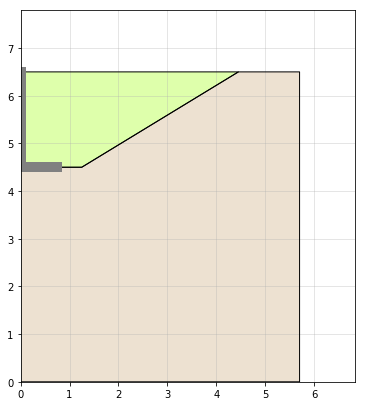

In [309]:
mdl, fig = build_model(title, comments, B, D, fill_angle, mesh_density, material)
fig

In [310]:
set_load_test(g_i, mdl, 'pullout5', 'construction', 5)
set_load_test(g_i, mdl, 'pullout10', 'construction', 10)
set_load_test(g_i, mdl, 'pullout15', 'construction', 25)
set_load_test(g_i, mdl, 'pullout20', 'construction', 20)

g_i.calculate()
results_df = get_results(mdl, g_i, g_o)

In [303]:
results_df['phase'].unique()

array(['construction', 'pullout_stage_0'], dtype=object)

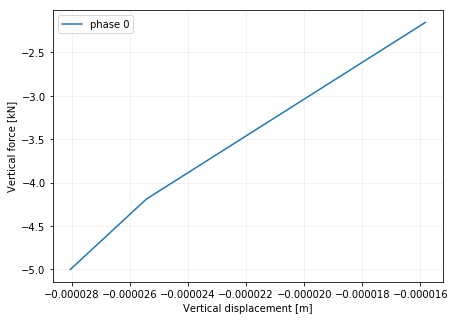

In [312]:
plot_test(results_df, 'pullout5')

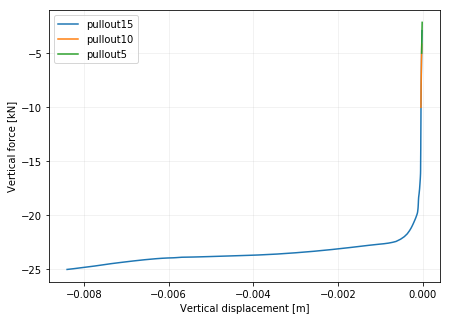

In [316]:
plot_test_compare(results_df, ['pullout15', 'pullout10', 'pullout5'])

In [294]:
set_load_test(g_i, mdl, 'bearing', 'construction', -100)
set_load_test(g_i, mdl, 'pullout', 'construction', [-20, 5])
set_load_test(g_i, mdl, 'pullout_cycles', 'construction', [-20, 5, -30, 5])

g_i.calculate()
results_df = get_results(mdl, g_i, g_o)

No handles with labels found to put in legend.


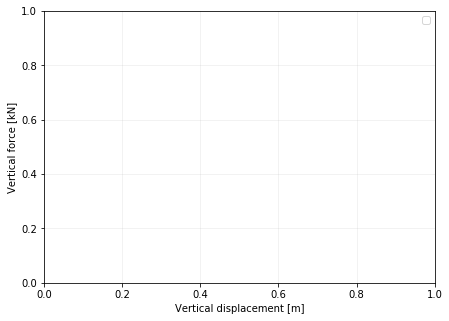

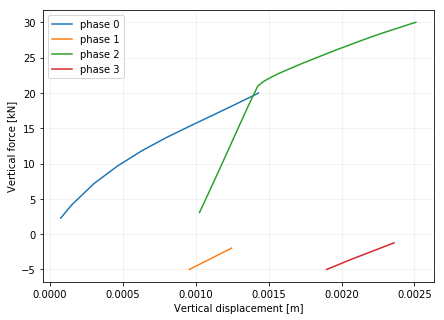

In [297]:
plot_test(results_df, 'pullout_cycles')

In [290]:
results_df['phase'].unique()

array(['construction', 'bearing_stage_0', 'pullout_stage_0',
       'pullout_stage_1', 'pullout_cycles_stage_0',
       'pullout_cycles_stage_1', 'pullout_cycles_stage_2',
       'pullout_cycles_stage_3'], dtype=object)

In [291]:
results_df.loc[results_df['phase']=='pullout_stage_0']

,load start,load end,uy,fy,sumMstage,phase,plx id,previous plx id,previous,test
0,0,-20,-0.002243,-2.270633,0.113532,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout
1,0,-20,-0.002318,-4.132485,0.206624,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout
2,0,-20,-0.002472,-7.168377,0.358419,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout
3,0,-20,-0.002633,-9.660704,0.483035,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout
4,0,-20,-0.002801,-11.823309,0.591165,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout
5,0,-20,-0.002972,-13.724881,0.686244,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout
6,0,-20,-0.003141,-15.424122,0.771206,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout
7,0,-20,-0.003301,-16.993235,0.849662,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout
8,0,-20,-0.003450,-18.469673,0.923484,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout
9,0,-20,-0.003590,-19.881788,0.994089,pullout_stage_0,Phase_4,Phase_2,pullout_stage_0,pullout


In [292]:
results_df.loc[results_df['phase']=='pullout_stage_1']

,load start,load end,uy,fy,sumMstage,phase,plx id,previous plx id,previous,test
0,0,5,-0.003415,1.978441,0.395688,pullout_stage_1,Phase_5,Phase_4,pullout_stage_1,pullout
1,0,5,-0.003233,3.883438,0.776688,pullout_stage_1,Phase_5,Phase_4,pullout_stage_1,pullout
2,0,5,-0.003125,5.000000,1.000000,pullout_stage_1,Phase_5,Phase_4,pullout_stage_1,pullout
